In [ ]:
%%html
<style>
table {display: block;}
td {
  font-size: 20px
}
.rendered_html { font-size: 20px; }
*{ line-height: 200%; }
</style>
<style type="text/css" media="print"> body { -webkit-print-color-adjust: exact; } </style>

# Natural Language Processing and the Web WS 2024/25 - Practice Class - *Week 07*

In this tutorial, we will continue with LLMs with focus on generative models, and how to use LLMs with langchain for RAG.
Content
   * Text classification with generative models
   * Instruction Tunning using Llama2
   * Introduction to Langchain
   
The content of this notebook is based on the rsources mentioned at the end of the notebook.

*This notebook is optimized for GPU usage. While we have successfully run the code on Google Colab, we cannot guarantee seamless performance due to variations in GPU availability and usage. Please ensure your GPU is operational, and be mindful of potential GPU limits during execution.*

# Text Classification with Generative Models
Classification with generative language models, such as OpenAI’s GPT models or Meta's Llama models, works differently than what we did in the previous week with task-specific encoder-only models. These generative models take text as input and generate text as output. They have no idea what to with input text, unless you provide some guildeline or instructions, what you want from the model.

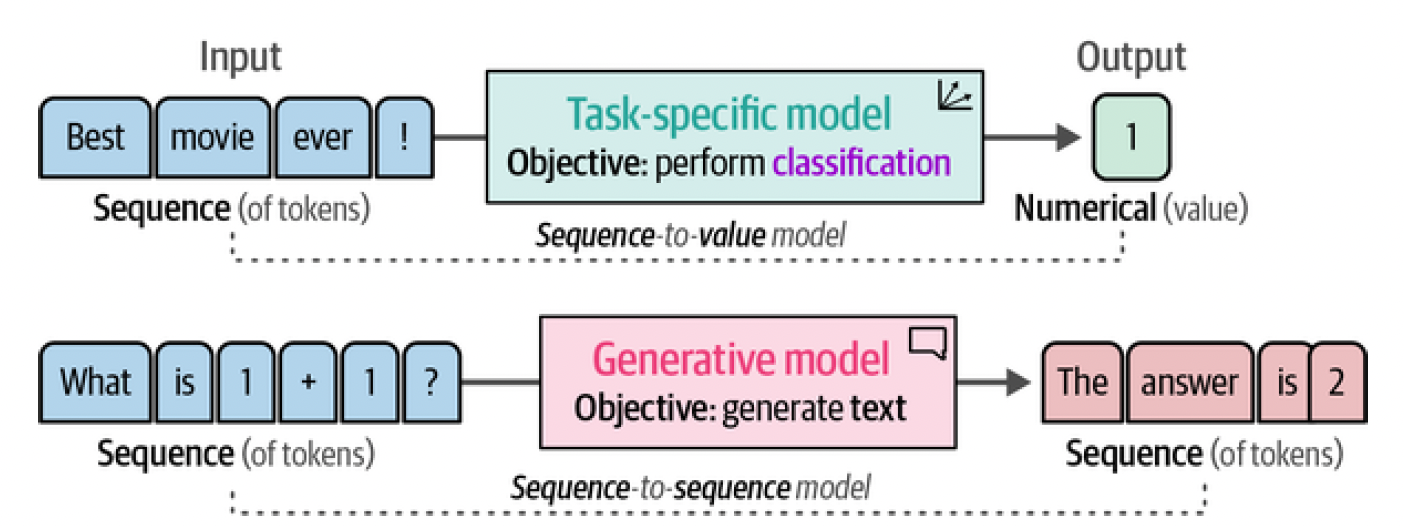

### Prompt-Engineering:
These instruction or guidelines are provided in the form **prompt**, and the process of iteratively improving the prompt to get required output from the model is called **prompt-engineering**.

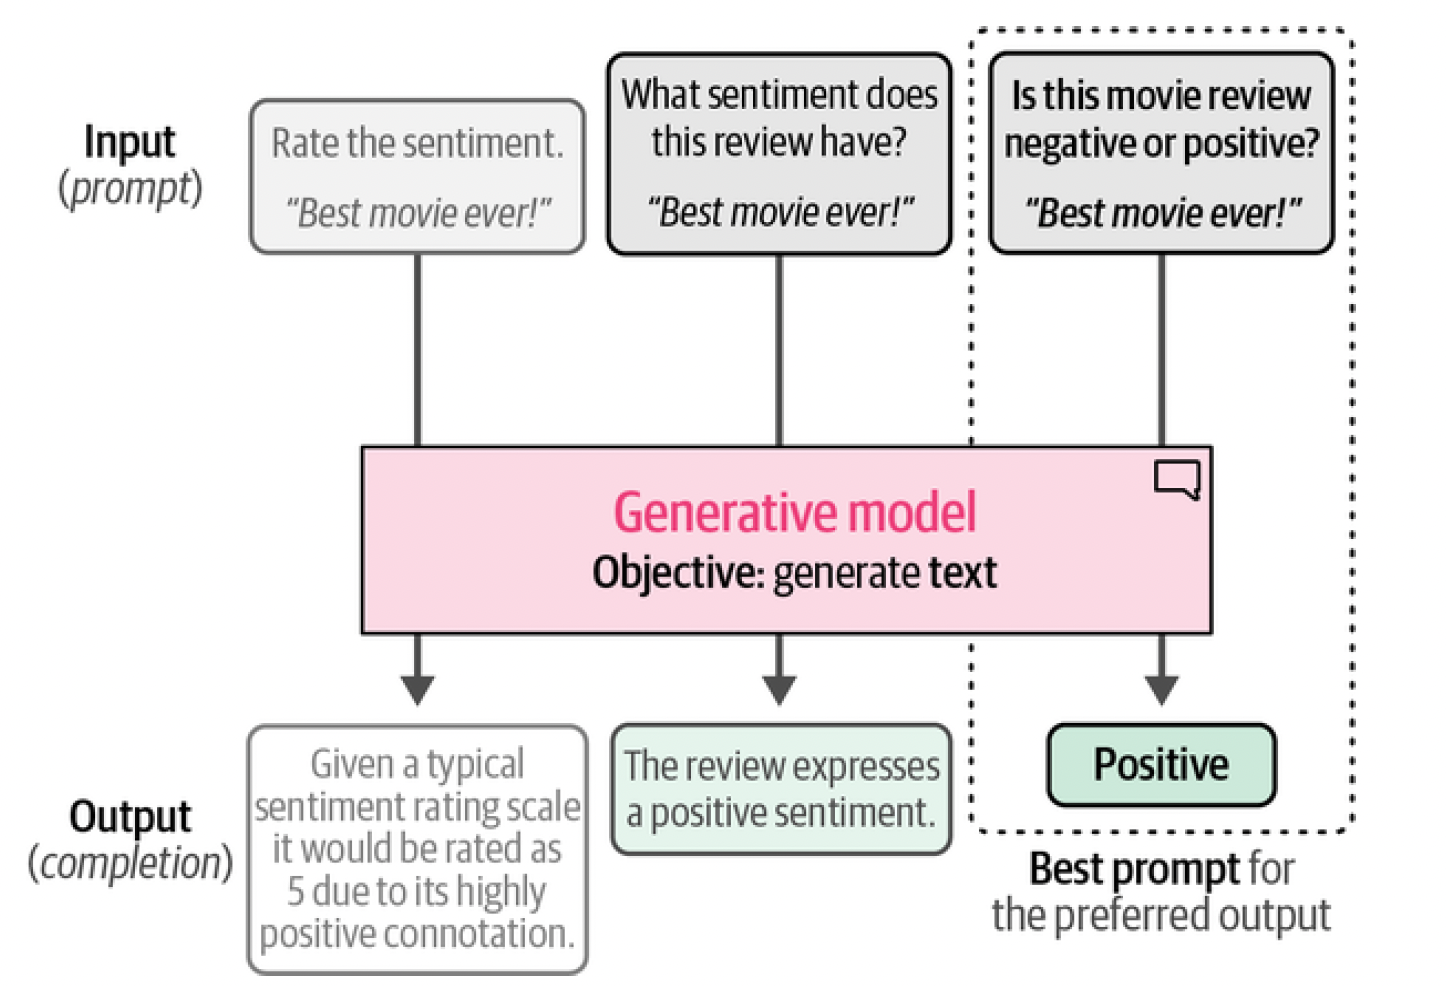

In [ ]:
! pip install transformers datasets

## With Text-to-Text Transfer Transformer (T5)

Sequence-to-sequence models also normally comes under the umbrella of generative models. One such family of models is T5, which was first pretrained using masked language modeling, and then fine-tuned on multiple tasks simultaneously. Each task was converted to a sequence-to-sequence task.

 Flan-T5 family is further improvement on the original T5 models, which introduced more than a thousand tasks during fine-tuning.

 For details check:
 * T5: [Exploring the Limits of Transfer Learning with a Unified
Text-to-Text Transformer](https://arxiv.org/pdf/1910.10683)
 * Flan-T5: [Scaling Instruction-Finetuned Language Models](https://arxiv.org/pdf/2210.11416)

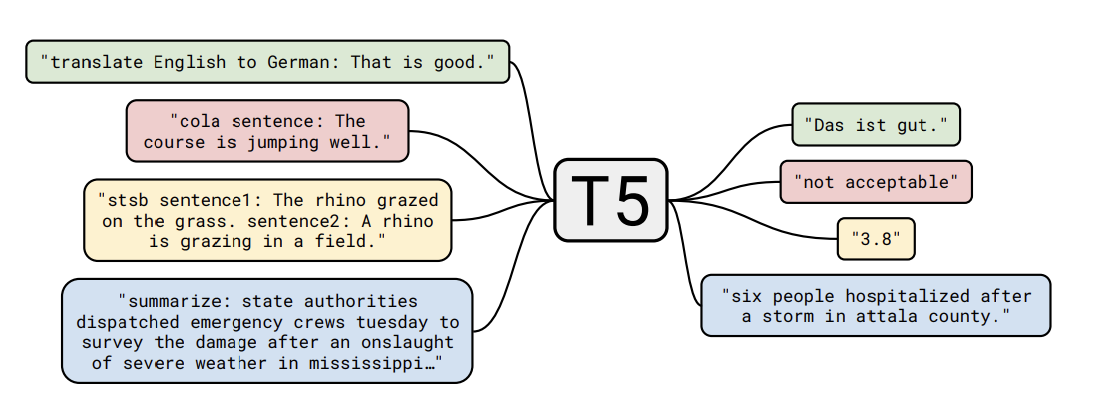

In [ ]:
from transformers import pipeline
# Load the model
pipe = pipeline(
"text2text-generation",
model="google/flan-t5-small",
device="cuda:0"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
prompt = "Is the following sentence positive or negative? "
pipe([prompt+"The movie was awesome",
      prompt+"The story was just boring"])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'positive'}, {'generated_text': 'negative'}]

In [ ]:
# load dataset
from datasets import load_dataset
dataset_id = "rotten_tomatoes"
dataset = load_dataset(dataset_id)
dataset

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [ ]:
# Map the dataset to add prompt
dataset = dataset.map(lambda example: {"t5_prompt": prompt + example['text']})
dataset["train"][0]

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1,
 't5_prompt': 'Is the following sentence positive or negative? the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .'}

In [ ]:
# Run inference
import numpy as np
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset
y_pred = []
for output in tqdm(pipe(KeyDataset(dataset["test"], "t5_prompt")), total=len(dataset["test"])):
  text = output[0]["generated_text"]
  y_pred.append(0 if text == "negative" else 1)



100%|██████████| 1066/1066 [00:46<00:00, 22.69it/s]


In [ ]:
# evaluate
from sklearn.metrics import classification_report
class_names = ["Negative", "Positive"]
result = classification_report(y_true=dataset["test"]["label"], y_pred=y_pred, target_names=class_names)
print(result)

              precision    recall  f1-score   support

    Negative       0.83      0.85      0.84       533
    Positive       0.85      0.83      0.84       533

    accuracy                           0.84      1066
   macro avg       0.84      0.84      0.84      1066
weighted avg       0.84      0.84      0.84      1066



## With OpenAI's ChatGPT

In [ ]:
! pip install openai

In [ ]:
import openai
from google.colab import userdata
OpenAI_Key = userdata.get('OpenAI_ChatGPT_Key')

openai_client = openai.OpenAI(api_key=OpenAI_Key)

---

In [ ]:
def chatgpt_generation(prompt, document, model="gpt-3.5-turbo-0125"):
    """Generate an output based on a prompt and an input document."""
    messages=[
            # {
            # "role": "system",
            # "content": "You are a helpful assistant." # a fixed role
            # },
            {
            "role": "user",
            "content":   prompt.replace("[DOCUMENT]",  document)
            }
    ]

    chat_completion = openai_client.chat.completions.create(
      messages=messages,
      model=model,
      temperature=0
    )
    return chat_completion.choices[0].message.content


In [ ]:
prompt1 = """Predict whether the following sentence is a positive or negative movie review:
[DOCUMENT]
"""


prompt = """Predict whether the following sentence is a positive or negative movie review:
[DOCUMENT]
If it is positive return 1 and if it is negative return 0. Do not give any other answers.
"""


In [ ]:
chatgpt_generation(prompt, "The movie was awesome")

'1'

### Run on Test Dataset
Please keep in mind that openAI models are not free to use. You need to keep an eye on how different models cost for input and outputs.

In [ ]:
from datasets import load_dataset
dataset_id = "rotten_tomatoes"
dataset = load_dataset(dataset_id)
dataset = dataset['test'].shuffle(seed=42).select(range(200)) # sample to make it quick


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
if False: # We disable running this so we save credit!
  predictions = [chatgpt_generation(prompt, doc) for doc in tqdm(dataset["text"])]
  y_pred = [int(pred) for pred in predictions]

In [ ]:
# evaluate
if False:
  from sklearn.metrics import classification_report
  class_names = ["Negative", "Positive"]
  result = classification_report(y_true=dataset["label"], y_pred=y_pred, target_names=class_names)
  print(result)

## With Meta's Llama Models
* You can either use Llama models via API (but its not free), OR
* Use transformers library (need to have access to meta models, you can apply for it via your hugging face account)
This is free but you need to setup a bit of code before you can use it for prompting.


Check for more methods: https://www.llama.com/docs/getting_the_models

### Via *API*
Llama has its own API and you can also access it via OpenAI's API as well.

In [ ]:
import openai
from google.colab import userdata
# specify URL
llama_client = openai.OpenAI(
                            api_key = userdata.get('Meta_Llama_Key'),
                            base_url = "https://api.llama-api.com"
                            )


def llama_generation(prompt, document, model="llama3.1-8b"):
    """Generate an output based on a prompt and an input document."""
    messages=[
            {
            "role": "user",
            "content":   prompt.replace("[DOCUMENT]",  document)
            }
    ]

    chat_completion = llama_client.chat.completions.create(
      messages=messages,
      model=model,
      temperature=0
    )
    return chat_completion.choices[0].message.content


In [ ]:
llama_generation(prompt1, "The movie was awesome")

'This sentence is a positive movie review. The word "awesome" has a strongly positive connotation, indicating that the reviewer enjoyed the movie.'

In [ ]:
llama_generation(prompt, "The movie was awesome")

'1'

## Via Transfomers and Hugging Face

To access such large models via loading them to local machine is a highly resource intensive task. We can quantize the model, loading it in **8-bit or even 4-bit** mode to reduce memory usage.

We can use conversational inference using the **pipeline** abstraction with **text-generation** task.


For details check: https://huggingface.co/blog/llama3#how-to-prompt-llama-3


Before using the Llama instruct model, you need to be approved. Go to the following link and request approval: https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct. You will need to fill in your personal information. The approval will take some time, maybe a couple of minutes or even more. Once approved, you will get an email [access granted] from Hugging Face.

In [ ]:
!pip uninstall bitsandbytes

In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 5.4 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login
from google.colab import userdata
# assuming google secrets has the hugging face access key with name "HF_TOKEN"
HF_TOKEN = userdata.get('HF_TOKEN')
login(token=HF_TOKEN)

In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

model_kwargs={
        "torch_dtype": torch.bfloat16, #ype used by the original checkpoint published by Meta, float16 is also correct and might be faster
        "quantization_config": {"load_in_4bit": True}, # loading the model in 4bit to use less memory
        "low_cpu_mem_usage": True,
    }


# ___________ to use  batching with pipeline, otherwise not required
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          padding_side='left', # to avoid warning for decoder only models, set the padding to left
                                          **model_kwargs)
if tokenizer.pad_token is None: #
    tokenizer.pad_token_id = AutoModelForCausalLM.from_pretrained(model_id, **model_kwargs).config.eos_token_id

# ____________________________________________________


pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    tokenizer=tokenizer,
    model_kwargs=model_kwargs,
    device_map="cuda:0", #if auto on a multi gpu server, it may use all avalable gpu's
)

# llama-3 related terminators to determine when to stop text generation
terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")

]


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def format_prompt(prompt, document):
    messages=[
            {
            "role": "user",
            "content":   prompt.replace("[DOCUMENT]",  document)
            }
        ]

    return messages


def llama_generation(messages, pipeline=pipeline):
    outputs = pipeline(
    messages,
    max_new_tokens=128,
    eos_token_id=terminators,
    pad_token_id = pipeline.tokenizer.eos_token_id,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    return_full_text=False # to just get assistant/newly added response text
    )
    return outputs[0]["generated_text"]


In [ ]:
review = "The movie was awesome"
llama_generation(format_prompt(prompt1, review))


'A simple one!\n\nI predict that this sentence is a **positive** movie review. The word "awesome" is a strong positive adjective that indicates the reviewer thoroughly enjoyed the movie.'

In [ ]:
llama_generation(format_prompt(prompt, review))

'1'

### Run on Test Dataset


In [ ]:
from datasets import load_dataset
dataset_id = "rotten_tomatoes"
dataset = load_dataset(dataset_id)

dataset = dataset.map(lambda example: {"prompt": format_prompt(prompt, example["text"])})
dataset = dataset['test'].shuffle(seed=42).select(range(200)) # sample to make it quick


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
from tqdm.auto import tqdm
from transformers.pipelines.pt_utils import KeyDataset

predictions = []
for outputs in tqdm(pipeline(KeyDataset(dataset, "prompt"),
                                max_new_tokens=1,
                                eos_token_id=terminators,
                                pad_token_id = pipeline.tokenizer.eos_token_id,
                                do_sample=True,
                                temperature=0.6,
                                top_p=0.9,
                                return_full_text=False,
                                batch_size=64,
                            ),
                    total = len(dataset)

                    ):


    predictions += [out["generated_text"] for out in outputs]


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
y_pred = [int(pred) for pred in predictions]

In [ ]:
# evaluate
from sklearn.metrics import classification_report
class_names = ["Negative", "Positive"]
result = classification_report(y_true=dataset["label"], y_pred=y_pred, target_names=class_names)
print(result)

              precision    recall  f1-score   support

    Negative       0.94      0.83      0.88       107
    Positive       0.83      0.94      0.88        93

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.89      0.88      0.88       200



# Langchain and Retrieval Agumented Generation (RAG)
Retrieval Augmented Generation (RAG) is a powerful technique that enhances language models by combining them with external knowledge bases. RAG addresses a key limitation of models: models rely on fixed training datasets, which can lead to outdated or incomplete information.

**`LangChain`** is a Python framework for developing applications powered by large language models (LLMs). It has a number of components specifically designed to help build RAG applications.

A typical RAG application has two main components:

**Indexing:** a pipeline for ingesting data from a source and indexing it. This usually happens offline.

**Retrieval and generation:** the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

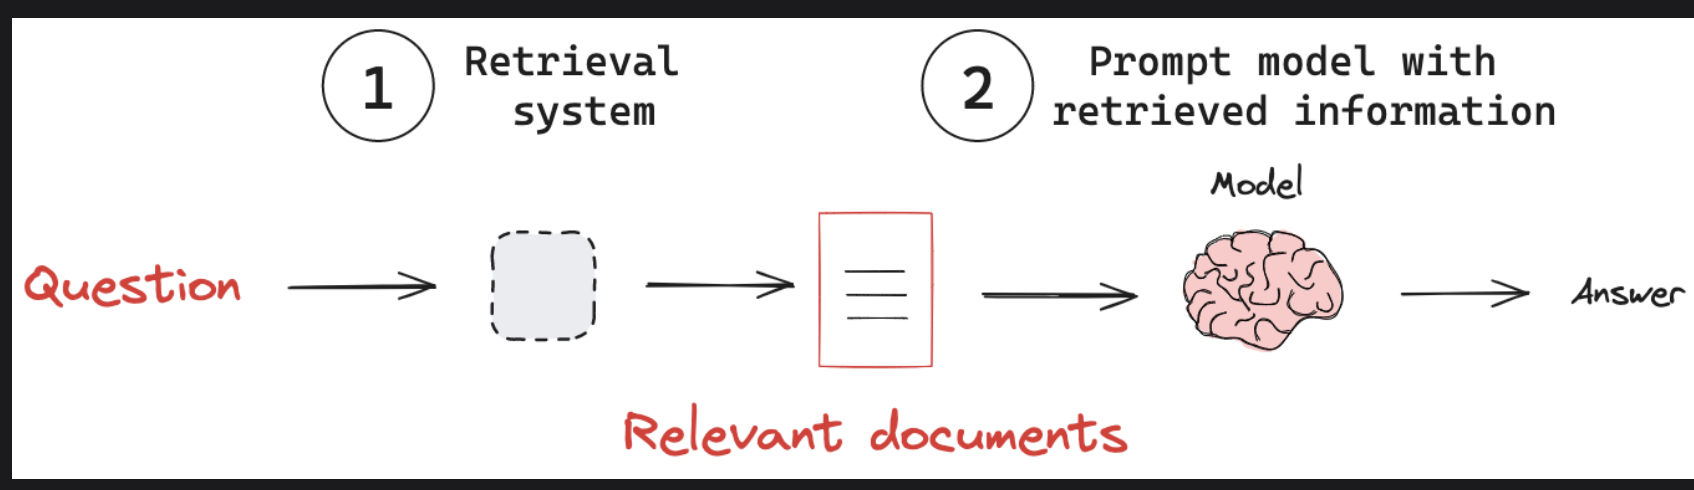

## Indexing
Langchain is a python framework to implement RAG systems with built-in components.

Indexing happens with the following steps:
- **`load`** the dataset using Dataloaders, langchain provides differen dataloaders for different type of data sources like CSV, PDF, Web etc.
- **`split`** documents into chunks using Text splitters, to make it easy for indexing.
- **`embed`** the chunks using an emnedding model, few options available in langchain are from OpenAI, Google, and HuggingFace etc
- **`store`** the emeddings into a VectorStore, like Chroma, Qdrant, mongoDB, and FAISS etc

![process](https://python.langchain.com/assets/images/rag_indexing-8160f90a90a33253d0154659cf7d453f.png)

## Retrieval and Generation
Once the document are stored, the **`retrieval`** is perfromed based on text similarity, and **`generation`** is done via LLM which produces an answer using a prompt that include the question and the retrieved data.

![retrieve and answer](https://python.langchain.com/assets/images/rag_retrieval_generation-1046a4668d6bb08786ef73c56d4f228a.png)

## A RAG based Application

 In this exercise, we will use [Langchain](https://www.langchain.com/) for a RAG experiment. MNake sure to generate API Key and store in your Google Colab `secret`. We first read PDF documents and use LLM to ask questions from the document.
In this tutorial, we'll build a simple question-answering application over a text data source from PDF documents.



In [ ]:

!pip install -U langchain-core
!pip install -U pypdf
!pip install -U langchain-text-splitters
!pip install -U langchain_huggingface
!pip install -U langchain-chroma
!pip install -U langgraph
!pip install -U langchain-community
!pip install -U langchain_openai

ERROR: unknown command "inst!pip"
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.9 MB/s eta 0:00:00


In [ ]:
## setup keys
import os
from google.colab import userdata
OpenAI_Key = userdata.get("OpenAI_ChatGPT_Key")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")

### Load data
We will use a pdf document as our data source

In [ ]:
import requests
from langchain_community.document_loaders import PyPDFLoader

# German family law in English
pdfurl = "https://www.gesetze-im-internet.de/englisch_gg/englisch_gg.pdf"
r = requests.get(pdfurl, allow_redirects=True)
file_path = "temp.pdf"
with open(file_path, 'wb') as fp:
    fp.write(r.content)

loader = PyPDFLoader(file_path)
docs = loader.load()
# number of pages
print(len(docs))

46


In [ ]:
print(f"{docs[0].page_content[:200]}\n")
print(docs[0].metadata)

Service provided by the Federal Ministry of Justice 
and the Federal Office of Justice ‒ www.gesetze-im-internet.de 
 
Page 1 of 46 
Übersetzung durch Professor Christian Tomuschat, Professor David P.

{'source': 'temp.pdf', 'page': 0}


### Split
RecursiveCharacterTextSplitter, is the recommended text splitter for generic text use cases. It will recursively split the document using common separators like new lines until each chunk is the appropriate size. The overlap will help to mitigate the possibility of separating a statement from important context related to it.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

257

In [ ]:
all_splits[0]

Document(metadata={'source': 'temp.pdf', 'page': 0, 'start_index': 0}, page_content='Service provided by the Federal Ministry of Justice \nand the Federal Office of Justice ‒ www.gesetze-im-internet.de \n \nPage 1 of 46 \nÜbersetzung durch Professor Christian Tomuschat, Professor David P. Currie, Professor Donald P. \nKommers und Raymond Kerr, in Kooperation mit dem Sprachendienst des Deutschen Bundestages \nTranslated by Professor Christian Tomuschat, Professor David P. Currie, Professor Donald P. \nKommers and Raymond Kerr, in cooperation with the Language Service of the German Bundestag \n \nStand: Die Übersetzung berücksichtigt die Änderung(en) des Gesetzes durch das Gesetz vom 19. \nDezember 2022 (BGBl. I S. 2478) \n \nVersion information: The translation includes the amendment(s) to the Act by the Act of 19 December \n2022 (Federal Law Gazette I p. 2478) \n \nZur Nutzung dieser Übersetzung lesen Sie bitte den Hinweis auf www.gesetze-im-internet.de unter \n"Translations". \nFor co

### Embeddings
We will use free option of HuggingFace with sentence embeddings. Others options will need API keys and also includes paid models as well.

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Vector Store
Different vector store might require different arguments when instantiated.
We will use Chroma vector store here.

In [ ]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings_model)
_ = vector_store.add_documents(documents=all_splits)


In [ ]:
# Once the documents are indexed, you can retrieva similar chunks for a query
user_question = """
According to German law, can children be separated from their families?
"""
retrieved_docs = vector_store.similarity_search(user_question)

print(retrieved_docs[0])

page_content='Service provided by the Federal Ministry of Justice 
and the Federal Office of Justice ‒ www.gesetze-im-internet.de 
 
Page 5 of 46 
(1) No German may be deprived of his citizenship. Loss of citizenship may occur only pursuant to a 
law and, if it occurs against the will of the person affected, only if he does not become stateless as a 
result. 
(2) No German may be extradited to a foreign country. The law may provide otherwise for extraditions 
to a member state of the European Union or to an international court, provided that the rule of law is 
observed. 
Article 16a 
[Right of asylum] 
(1) Persons persecuted on political grounds shall have the right of asylum. 
(2) Paragraph (1) of this Article may not be invoked by a person who enters the federal territory from a 
member state of the European Communities or from another third state in which application of the 
Convention Relating to the Status of Refugees and of the Convention for the Protection of Human' metadata={'

### LLM-Chat model
A chat model (LLM) is needed to generate a human-like response rather than just retrieving similar chunks.

In [ ]:
from langchain_openai import ChatOpenAI

#llm = ChatOpenAI(openai_api_key=OpenAI_Key, model="gpt-3.5-turbo")
llm = ChatOpenAI(openai_api_key=OpenAI_Key, model="gpt-4o-mini")


### Retrieval and Generation

1. take a user question and search the documents relevant to that question,
2. passes the retrieved documents and the initial question to a chat model, and returns an answer.

In [ ]:
from langchain import hub

# pull rag prompt
prompt = hub.pull("rlm/rag-prompt")


def retrieve_and_generate(question):
  # retrieve
  retrieved_docs = vector_store.similarity_search(question)
  docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
  # generate
  messages = prompt.invoke({"question": user_question, "context": docs_content})
  answer = llm.invoke(messages)
  return answer.content


In [ ]:
from langchain.callbacks import get_openai_callback # to trace the cost with openAI models

user_question = """
According to German law, can children be separated from their families?
"""

if user_question:
  with get_openai_callback() as cb:
    response = retrieve_and_generate(user_question)
    print(response+'\n')
    print(cb)

The retrieved context does not provide specific information about whether children can be separated from their families under German law. Therefore, I don't know the answer to your question.

Tokens Used: 921
	Prompt Tokens: 889
	Completion Tokens: 32
Successful Requests: 1
Total Cost (USD): $0.00015255


The model still remember the first question and we can ask related question.

In [ ]:

user_question = """
 With whom can the children stay?
"""

if user_question:
  with get_openai_callback() as cb:
    response = retrieve_and_generate(user_question)
    print(response+'\n')
    print(cb)

Children can stay with their parents or guardians, as the care and upbringing of children is primarily their natural right and duty. The state has the responsibility to oversee this duty. Separation from their families can occur only under specific legal conditions, such as parental failure or risk of serious neglect.

Tokens Used: 890
	Prompt Tokens: 834
	Completion Tokens: 56
Successful Requests: 1
Total Cost (USD): $0.00015869999999999998


----
----

<span style="color:red">Note:</span> Restart the kernel for this part to clear the memory and to avoid any version conflicts


# Fine-tuning Llama
We will fine-tune one of the smallest model from Llama family of models which are freely available to use and finetune.


# Parameter-Efficient Fine-Tuning (PEFT)
PEFT is a strategy to adapt pre-trained models to new tasks with least changes possible to the existing model. PEFT is important mainly for fast training and ability to run on low-end resources. There are two important PEFT methods:

# LoRA (Low Rank Adaption) and QLoRA (Quantized-LoRA)
These methods allow training with drastically reduced trainable parameters. As low as 10k times lower than the original models. It also enable a three-fold reduction in GPU requirements. It is done by loading pre-trained model's existing weights to GPU as quantized 8-bit and 4-bit weights, respectively.


In [ ]:
!pip install transformers accelerate huggingface_hub
!pip install -U bitsandbytes
!pip install -U peft
!pip install -U trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 21.6 MB/s eta 0:00:00


In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)

from trl import SFTTrainer, SFTConfig, setup_chat_format

In [ ]:
from huggingface_hub import login
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

# notebook_login()
login(token=HF_TOKEN)

# Model and tokenizer
We use the the smallest version of llama from hugging face. To have access to these models you need to apply via hugging face account.

For Llama-3.2-1B-Instruct, you can access from this link: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct

In [ ]:
# Model id
# model_id = "meta-llama/Llama-3.1-8B-Instruct"
model_id = "meta-llama/Llama-3.2-1B-Instruct" # smallest model

refined_model = "Llama-3-chat"


To reduce the model size and increase inference speed, we use a 4-bit quantization provided by the `BitsAndBytesConfig`. Quantizing the model means representing its weights in a way that uses less memory. The configuration here uses the `nf4` type for quantization. Experiment with different quantization types to see potential performance variations.

In [ ]:
# QLoRA config
bnb_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type="nf4", # nf4 ==> 4-bit NormalFloat
      bnb_4bit_compute_dtype="float16",
      bnb_4bit_use_double_quant=True
    )


In [ ]:

# Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
    )

model.config.use_cache=False
model.config.pretraining_tp=1


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:

# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix for fp16


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

### Add Special Tokens for Chat Format

Adding special tokens to a language model is crucial for training chat models. These tokens are added between the different roles in a conversation, such as the user, assistant, and system and help the model recognize the structure and flow of a conversation. This setup is essential for enabling the model to generate coherent and contextually appropriate responses in a chat environment.

The **[setup_chat_format()](https://huggingface.co/docs/trl/main/en/sft_trainer#add-special-tokens-for-chat-format)** function in **trl** will do that for us. The default template is chatml from OpenAI, which will convert the input text into a chat-like format.

In [ ]:
tokenizer.chat_template=None # set existing template to None (If any)
model, tokenizer = setup_chat_format(model, tokenizer)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


# LoRA-Specific Parameters

* `Dropout Rate (lora_dropout)`: This is the probability that each neuron’s output is set to zero during training, used to prevent overfitting.
* `Rank (r)`: Rank is essentially a measure of how the original weight matrices are broken down into simpler, smaller matrices. This reduces computational requirements and memory consumption. Lower ranks make the model faster but might sacrifice performance. The original LoRA paper suggests starting with a rank of 8, but for QLoRA, a rank of 64 is required.
* `lora_alpha`: This parameter controls the scaling of the low-rank approximation. It’s like a balancing act between the original model and the low-rank approximation. Higher values might make the approximation more influential in the fine-tuning process, affecting both performance and computational cost. *A rule of thumb is to choose a value twice the size of r.*
* `target_modules`: Controls which layers to target. The LoRA procedure can choose to ignore specific layers, like specific projection layers. This can speed up training but reduce performance and vice versa.


In [ ]:
# LoRA Config
peft_parameters = LoraConfig(
    r=16,
    lora_alpha=64,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)


# Prepare model for training
model = prepare_model_for_kbit_training(model)
base_model = get_peft_model(model, peft_parameters)


# Dataset
Get your dataset and format it into conversational format.
<!-- we will use the subset of the *Open Assistant dataset*. This dataset was used to train Guanaco with QLoRA. The dataset is availabel [here](https://huggingface.co/datasets/timdettmers/openassistant-guanaco). -->

In [ ]:
# Dataset
dataset_id = "HuggingFaceH4/ultrachat_200k"

# Load a small sample of dataset
dataset = load_dataset(dataset_id,  split="test_sft").shuffle(seed=42).select(range(500))

dataset

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

(…)-00000-of-00003-a3ecf92756993583.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00001-of-00003-0a1804bcb6ae68c6.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00002-of-00003-ee46ed25cfae92c6.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00000-of-00001-f7dfac4afe5b93f4.parquet:   0%|          | 0.00/81.2M [00:00<?, ?B/s]

(…)-00000-of-00003-a6c9fb894be3e50b.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00001-of-00003-d6a0402e417f35ca.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

(…)-00002-of-00003-c0db75b92a2f48fd.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

(…)-00000-of-00001-3d4cd8309148a71f.parquet:   0%|          | 0.00/80.4M [00:00<?, ?B/s]

Generating train_sft split:   0%|          | 0/207865 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/23110 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/256032 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/28304 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'prompt_id', 'messages'],
    num_rows: 500
})

In [ ]:
dataset[0]

{'prompt': "Write a compelling mystery story set in a vineyard, where a seasoned detective investigates a murder with twists and turns that will keep the reader engaged until the very end. Add complex characters, multiple suspects, and red herrings to create suspense and challenge the detective's deductive reasoning. Use vivid descriptive language to paint a picture of the vineyard setting, its wine-making process, and the people who live and work there. Make sure to reveal clues and motives gradually, and create a satisfying resolution that ties up all loose ends.",
 'prompt_id': 'a59f5664bebecec40565355945c2b124b40b891096d9dfc807812fe33c7b8e47',
 'messages': [{'content': "Write a compelling mystery story set in a vineyard, where a seasoned detective investigates a murder with twists and turns that will keep the reader engaged until the very end. Add complex characters, multiple suspects, and red herrings to create suspense and challenge the detective's deductive reasoning. Use vivid 

In [ ]:
def format_chat_template(row):
  row["text"] = tokenizer.apply_chat_template(row["messages"], tokenize=False)
  return row

training_data = dataset.map(format_chat_template, num_proc=4)

print(training_data['text'][156])


<|im_start|>user
Write a captivating story that follows the journey of a person who finds themselves stuck in a time loop, reliving the same day over and over again. The plot should showcase the repercussions of being caught in such a loop, the character's various attempts to break free, and the obstacles they face along the way. Craft the story in a way that effectively captures the character's emotions and thoughts, while maintaining a consistent and engaging narrative flow. The resolution should be both satisfying and plausible, leaving readers with a solid understanding of how the character ultimately achieves freedom from the time loop.<|im_end|>
<|im_start|>assistant
Anna woke up to the same day she had been living for the past few months. She rubbed her eyes and glanced at the clock, it was exactly 6 am. She let out a deep sigh and got up from the bed, knowing what was ahead of her. As she went through the day, she realized that she was stuck in a time loop, living the same day 

# Model Training
The model is trained using the `SFTTrainer`, which is specifically designed for this kind of task. After defining the trainer, the training process begins.

In [ ]:

train_params = SFTConfig(
    output_dir=refined_model,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    logging_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=True,
    # bf16=False,
    group_by_length=True,
    dataset_text_field="text",
    max_seq_length=512,
    report_to="none",
)

In [ ]:
# Trainer
trainer = SFTTrainer(
    model=base_model,
    train_dataset=training_data,
    peft_config=peft_parameters,
    processing_class=tokenizer,
    args=train_params,
)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# Training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.847000
20,1.751100
30,1.780800
40,1.789400
50,1.611400
60,1.593400


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=62, training_loss=1.7320593326322493, metrics={'train_runtime': 216.674, 'train_samples_per_second': 2.308, 'train_steps_per_second': 0.286, 'total_flos': 1480383996248064.0, 'train_loss': 1.7320593326322493, 'epoch': 0.992})

In [ ]:
# Save Model with QLoRA weights
trainer.model.save_pretrained(refined_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


# Loading Model
Once the model is trained, we need to merge it with base model, after merging, we can use it with the prompt template that we used to train the model.

We can merge the modified LoRA weights with the base model with `PeftModel`. We use the usual HuggingFace pipeline to use the model for **text generation**.

In [ ]:
from huggingface_hub import login
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

login(token=HF_TOKEN)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch
from trl import setup_chat_format


model_id = "meta-llama/Llama-3.2-1B-Instruct"
new_model = "Llama-3-chat"

# Reload tokenizer and model

tokenizer = AutoTokenizer.from_pretrained(model_id)
base_model_reload = AutoModelForCausalLM.from_pretrained(
        model_id,
        low_cpu_mem_usage=True,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
)

tokenizer.chat_template=None
base_model_reload, tokenizer = setup_chat_format(base_model_reload, tokenizer)

# Merge adapter with base model
model = PeftModel.from_pretrained(base_model_reload, new_model)

model = model.merge_and_unload()

In [ ]:
from transformers import pipeline
# define teh pipe based on fine-tuned model
pipe = pipeline(task="text-generation",
                model=model,
                tokenizer=tokenizer,
                max_new_tokens=256
                )

In [ ]:
# format message as per chat template
#1.  manually
prompt = """<|im_start|>user
Tell me something about Large Language Models.<|im_end|>
<|im_start|>assistant
"""
print(prompt)

<|im_start|>user
Tell me something about Large Language Models.<|im_end|>
<|im_start|>assistant



In [ ]:
# 2. Using tokenizer's apply_chat_template method
messages = [{"role":"user", "content":"Tell me something about Large Language Models."}]

prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|im_start|>user
Tell me something about Large Language Models.<|im_end|>
<|im_start|>assistant



In [ ]:
print(pipe(prompt)[0]["generated_text"])

<|im_start|>user
Tell me something about Large Language Models.<|im_end|>
<|im_start|>assistant
Large Language Models (LLMs) are a type of artificial intelligence (AI) that have revolutionized the field of natural language processing (NLP). They are designed to understand and generate human-like language, and have become increasingly powerful and accurate over time.

Here are some key features of LLMs:

1. **Training data**: LLMs are trained on large amounts of text data, which allows them to learn patterns and relationships in language. This training data can come from a variety of sources, including books, articles, websites, and social media platforms.

2. **Architecture**: LLMs are typically composed of multiple layers, including a transformer encoder, a language model, and a decoder. The transformer encoder is responsible for converting input text into a numerical representation that can be processed by the language model. The language model uses this numerical representation to g

# Resources
   * [Tex Classification with Genrative models](https://github.com/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter04/Chapter%204%20-%20Text%20Classification.ipynb)
   * [How to use Llama3 with Transformers](https://huggingface.co/blog/llama3#how-to-prompt-llama-3)
   * [Fine-tune Llama with LoRA-1](https://www.datacamp.com/tutorial/llama3-fine-tuning-locally?dc_referrer=https%3A%2F%2Fduckduckgo.com%2F)
   * [Fine-tune Llama with LoRA-2](https://github.com/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter12/Chapter%2012%20-%20Fine-tuning%20Generation%20Models.ipynb)
   *[Retrieval-augmented generation (RAG)](https://python.langchain.com/docs/tutorials/rag/)